## Binary Segmentation Model (Fruit vs. Background)

imports

In [23]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

Making sure that both sets have the same fruit types

In [24]:
trainFruits=os.listdir('Project Data/Fruit/Train')
testFruits=os.listdir('Project Data/Fruit/Validation')

In [25]:
assert set(trainFruits) == set(testFruits), "Train and Test folders must have the same fruit categories"

### Read all the file names first to shuffle them before generating a batch

In [26]:
fruits = trainFruits  
trainingPairs = []

for fruit in fruits:
    image_dir = f'Project Data/Fruit/Train/{fruit}/Images'
    mask_dir = f'Project Data/Fruit/Train/{fruit}/Mask'
    
    filenames = os.listdir(image_dir)
    
    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        
        mask_filename = f"{filename.split('.')[0]}_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)
        
        trainingPairs.append((img_path, mask_path))

random.shuffle(trainingPairs)

Size of the dataset

In [27]:
len(trainingPairs)

1759

Helper function

In [28]:
def read_and_process_image(path,size=(224,224)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    image = image / 255.0
    return image

In [29]:
def read_and_process_mask(path,size=(224,224)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size,interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.int32) 
    mask = np.expand_dims(mask, axis=-1)
    return mask

Batch generator

In [30]:
def get_batch(file_pairs, batch_size):
    L = len(file_pairs)
    random.shuffle(file_pairs) # shuffle each epoch
    
    for start in range(0, L, batch_size):
        end = min(start + batch_size, L)
        current_batch_pairs = file_pairs[start:end]
        
        x_batch = []
        y_batch = []
        
        for img_p, mask_p in current_batch_pairs:
            img = read_and_process_image(img_p)
            x_batch.append(img)
            
            mask = read_and_process_mask(mask_p)
            y_batch.append(mask)
        
        yield np.array(x_batch), np.array(y_batch)

### Plot a batch of images and masks

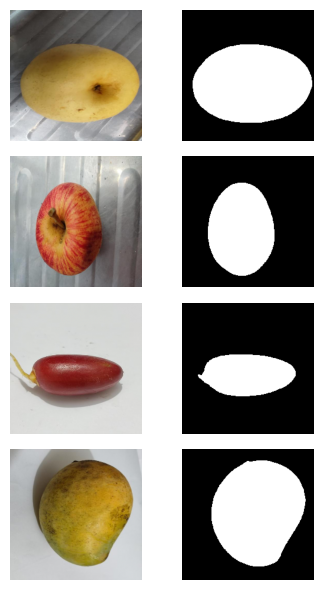

In [31]:
for x, y in get_batch(trainingPairs, 4):
    
    plt.figure(figsize=(4,6))
    
    for i in range(len(x)):
        
        plt.subplot(len(x), 2, 2*i + 1)
        plt.imshow(x[i])
        plt.axis("off")
        
        plt.subplot(len(x), 2, 2*i + 2)
        plt.imshow(y[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()
    
    break

In [32]:
import torch
import segmentation_models_pytorch as smp

# 1. Device Setup (Use GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. Create Model
model = smp.Unet(
    encoder_name="resnet34",        # The pre-trained backbone
    encoder_weights="imagenet",     # Load weights from ImageNet training
    in_channels=3,                  # RGB Input
    classes=1                       # Binary Output
)

# Move model to GPU
model.to(device)

# 3. Loss Function & Optimizer
# We use BCEWithLogitsLoss because the model outputs "Logits" (raw scores), 
# not probabilities (0-1). This function applies Sigmoid internally + calculates loss.
loss_fn = torch.nn.BCEWithLogitsLoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [34]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 8  # Adjust based on your GPU VRAM

# Training Loop
for epoch in range(EPOCHS):
    
    model.train() # Set model to training mode
    epoch_loss = 0
    
    # Initialize your generator
    # Assuming 'train_files' is your list of (image, mask) paths
    batch_generator = get_batch(trainingPairs, BATCH_SIZE)
    
    for x_np, y_np in batch_generator:
        
        # --- A. Data Prep ---
        # Convert numpy -> torch tensor -> float -> move to GPU
        x = torch.from_numpy(x_np).float().to(device)
        x = x.permute(0, 3, 1, 2)   
        # x is now [8, 3, 224, 224] -> Ready for Unet

        # Note: You likely need to do the same for 'y' if your mask is [8, 224, 224, 1]
        y = torch.from_numpy(y_np).float().to(device)
        y = y.permute(0, 3, 1, 2)
        # --- B. Forward Pass ---
        optimizer.zero_grad()       # Clear previous gradients
        pred_logits = model(x)      # Get model output (Logits)
        
        # --- C. Calculate Loss ---
        loss = loss_fn(pred_logits, y)
        
        # --- D. Backward Pass ---
        loss.backward()             # Calculate gradients
        optimizer.step()            # Update weights
        
        # Log loss
        epoch_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'my_binary_unet.pth')

KeyboardInterrupt: 